# Исследование данных развлекательного приложения Procrastinate Pro+
В нашем распоряжении данные о пользователях развлекательного приложения Procrastinate Pro+, привлечённых с 1 мая по 27 октября 2019 года (лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы). На их основе необходимо выяснить причину убытков компании, несмотря на большие вложения в рекламу. 

**Цель исследования:** разобраться в причинах убытков компании и помочь ей выйти в плюс. 

**Ход исследования**: перед тем, как выяснять причины убытков, необходимо изучить данные и провести их предобработку. Следовательно, исследование будет состоять из 2 этапов: 
- обзор и предобработка данных 
- проведение исследовательского анализа.

До этих этапов подготовимся к работе - импортируем необходимые библиотеки и опишем функции, которые будем вызывать в ходе исследований. 

## Подготовка к работе

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
#функция для вывода общей информации о датасете
def general_info(dataset):
    print(dataset.head())
    print()
    print(dataset.info())
    print()
    print(dataset.duplicated().sum())

In [3]:
#функция для создания сводной таблицы
def create_pivot_table(name):
    total_payers = '{:.2%}'.format(profiles['payer'].sum()/profiles['user_id'].nunique())
    table_1 = profiles.pivot_table(index=[name], values='user_id', aggfunc='nunique')
    table_2 = profiles.pivot_table(index=[name], values='payer', aggfunc='sum')
    table = table_1.merge(table_2, on=[name],how='left')
    table['%_payer'] = table['payer']/table['user_id']*100
    table = table.sort_values(by='%_payer', ascending=False)
    table['total_%_payers'] = total_payers
    return table                              

In [4]:
#функция для создания профилей пользователя с расчетом CAC
def get_profiles(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [5]:
#функция для подсчета Retention Rate
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # решаем какие столбцы оставим для группировки удержания, столбец признака платящего пользователя остается всегда
    dimensions = ['payer'] + dimensions
    
    # оттсекаем всех пользователей, которые не могли "дожить" до нужного горизонта 
    # (присоединились позже чем observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # формируем массив сырых данных
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция группировки по нужному набору измерений
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # строим "треугольную таблицу" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # определяем размеры когорт
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # присоединяем размеры когорт к треугольной таблице
        result = result.div(result['cohort_size'], axis = 0)                                                     # делим каждый из столбцов на размер когорты - расчитываем % удержания (retention rate)
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # оставляем только наблюдения до нужного горизонта и столбец размеров когорт
        result['cohort_size'] = cohort_sizes                                                                     # пересприсваиваем столбец размеров когорт, ведь во время деления он превратился в 1
        return result
    
    # расчитываем удержание 
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # рассчитываем удержание по всем параметрам + дата
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем и таблицы удержания и сырые данные (чтобы в случае чего можно было в них покопаться при отладке)
    return result_raw, result_grouped, result_in_time

In [6]:
#функция для подсчета конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [7]:
#функция для подсчета LTV
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [8]:
#функция для сглаживания данных 
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [9]:
#функция для построения графика Retention Rate
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [10]:
#функция для построения графика конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [11]:
#функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Обзор и предобработка данных

In [12]:
visits = pd.read_csv('visits.csv')
orders = pd.read_csv('orders.csv')
costs = pd.read_csv('costs.csv')

In [13]:
general_info(visits)

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null 

In [14]:
general_info(orders)

        User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

0


In [15]:
general_info(costs)

           dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

0


*Вывод:* Пропуски и дубликаты во всех трех датасетах отсутствуют. Необходимо изменить имена столбцов на "змеиный регистр", а также привести столбцы с датами к типу datetime.

In [16]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [17]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [18]:
visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

In [19]:
orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

In [20]:
costs.dtypes

dt          object
channel     object
costs      float64
dtype: object

*Вывод:* данные полностью готовы к проведению исследовательского анализа данных.

## Проведение исследовательского анализа данных

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователей. 

In [21]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [22]:
min_dt = profiles['dt'].min()
max_dt = profiles['dt'].max()

In [23]:
print(min_dt, max_dt)

2019-05-01 2019-10-27


*Вывод:* с помощью функции get_profiles мы создали профили пользователей приложения Procrastinate Pro+. В них указана дата первой сессии, канал привлечения, используемое устройство, регион и отметка о том, что пользователь совершал покупки в приложении, а также стоимость привлечения (CAC). Минимальная дата привлечения пользователей - 1 мая 2019 года, максимальная - 27 октября 2019 года.

С помощью функции create_pivot_table сгруппируем данные по странам, чтобы выяснить, где больше всего платящих пользователей. 

In [24]:
regions = create_pivot_table('region')
regions

,user_id,payer,%_payer,total_%_payers
region,,,,
United States,100002,6902,6.901862,5.92%
Germany,14981,616,4.111875,5.92%
UK,17575,700,3.982930,5.92%
France,17450,663,3.799427,5.92%


*Вывод:* больше всего платящих пользователей в США (6.9%). В остальных странах процент платящих пользователей не превышает общую долю в 5.92%. 

Составим такую же таблицу с группировкой по используемым пользователями устройствами. 

In [25]:
devices = create_pivot_table('device')
devices

,user_id,payer,%_payer,total_%_payers
device,,,,
Mac,30042,1912,6.364423,5.92%
iPhone,54479,3382,6.207897,5.92%
Android,35032,2050,5.851793,5.92%
PC,30455,1537,5.046790,5.92%


*Вывод:* больше всего платящих пользователей среди тех, кто использует устройства Mac (6.36%). Также процент платящих пользователей IPhone выше чем общий процент платящих пользователей (6.2% против 5.92%). У других устройств доля платящих пользователей ниже 5.92%.

Используем функцию create_pivot_table для группировки данных по каналам привлечения пользователей в приложение.

In [26]:
channels = create_pivot_table('channel')
channels

,user_id,payer,%_payer,total_%_payers
channel,,,,
FaceBoom,29144,3557,12.204914,5.92%
AdNonSense,3880,440,11.340206,5.92%
lambdaMediaAds,2149,225,10.469986,5.92%
TipTop,19561,1878,9.600736,5.92%
RocketSuperAds,4448,352,7.913669,5.92%
WahooNetBanner,8553,453,5.296387,5.92%
YRabbit,4312,165,3.826531,5.92%
MediaTornado,4364,156,3.574702,5.92%
LeapBob,8553,262,3.063253,5.92%


*Вывод:* больше всего платящих пользователей среди тех, кто пришел по каналу привлечения FaceBoom - 12.2%. Доля платящих пользователей из каналов привлечения AdNonSense, lambdaMediaAds, TipTop и RocketSuperAds превышает общее число платящих пользователей (11.34%, 10.47%, 9.6% и 7.91% соответственно). В остальных каналах привлечения доля платящих пользователей ниже 5.92%. 

**Вывод:** общая доля платящих пользователей составляет 5.92%. 

В разбивке по странам наибольшее число платящих пользователей в США (6.9%), наименьшее во Франции (3.8%). 

В разбивке по устройствам больше всего платящих среди пользователей Mac (6.36%), меньше всего у пользователей PC (5%). 

В разбивке по каналам привлечения больше всего платящих пользователей среди тех, кто пришел из FaceBoom (12.2%), меньше всего среди органических пользователей (2%).

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

Узнаем, сколько всего средств было потрачено на маркетинг.

In [27]:
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [28]:
marketing_expenses = costs['costs'].sum()
marketing_expenses

105497.30000000002

*Вывод:* общая сумма расходов на маркетинг приложения Procrastinate Pro+ составила 105 497 у.е.

Выясним, сколько денег было потрачено на каждый рекламный источник.

In [29]:
marketing_expenses_t = costs.pivot_table(index='channel', values='costs', aggfunc = 'sum').sort_values(by='costs', ascending = False)
marketing_expenses_t

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


*Вывод:* больше всего средств было потрачено на рекламу в Tip Top - 54 751.30 у.е., меньше всего - в YRabbit (944.22 у.е.).

Визуализируем динамику изменения расходов во времени (по неделям и месяцам) по каждому источнику. 

In [30]:
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs

,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,5,18
1,2019-05-02,FaceBoom,78.1,5,18
2,2019-05-03,FaceBoom,85.8,5,18
3,2019-05-04,FaceBoom,136.4,5,18
4,2019-05-05,FaceBoom,122.1,5,18
...,...,...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0,10,43
1796,2019-10-24,lambdaMediaAds,6.4,10,43
1797,2019-10-25,lambdaMediaAds,8.8,10,43
1798,2019-10-26,lambdaMediaAds,8.8,10,43


In [31]:
costs_month = costs.pivot_table(index='month', columns = 'channel', values='costs', aggfunc='sum')
costs_month

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,,,
5,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
6,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
7,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
8,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
9,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
10,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


In [32]:
costs_week = costs.pivot_table(index='week', columns = 'channel', values='costs', aggfunc='sum')
costs_week

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
week,,,,,,,,,,
18,211.05,535.7,16.80,38.64,24.00,99.450,347.0,49.2,52.20,81.6
19,273.00,750.2,31.71,61.68,34.50,139.230,470.0,92.4,75.90,103.2
20,265.65,755.7,26.67,59.04,27.50,138.060,454.0,90.0,69.30,90.4
21,266.70,722.7,26.67,50.16,34.25,131.040,801.8,79.2,65.40,119.2
22,202.65,1208.9,65.52,36.96,81.75,97.695,1421.2,179.4,49.80,83.2
23,102.90,1081.3,66.99,27.60,79.50,76.050,1223.6,196.8,25.80,35.2
24,96.60,1042.8,52.29,29.76,71.50,63.180,1121.0,166.2,17.46,45.6
25,141.75,1280.4,68.46,32.16,79.75,80.730,1474.4,201.6,22.14,40.0
26,148.05,1647.8,99.75,40.56,107.00,78.260,2343.6,285.0,27.90,59.2


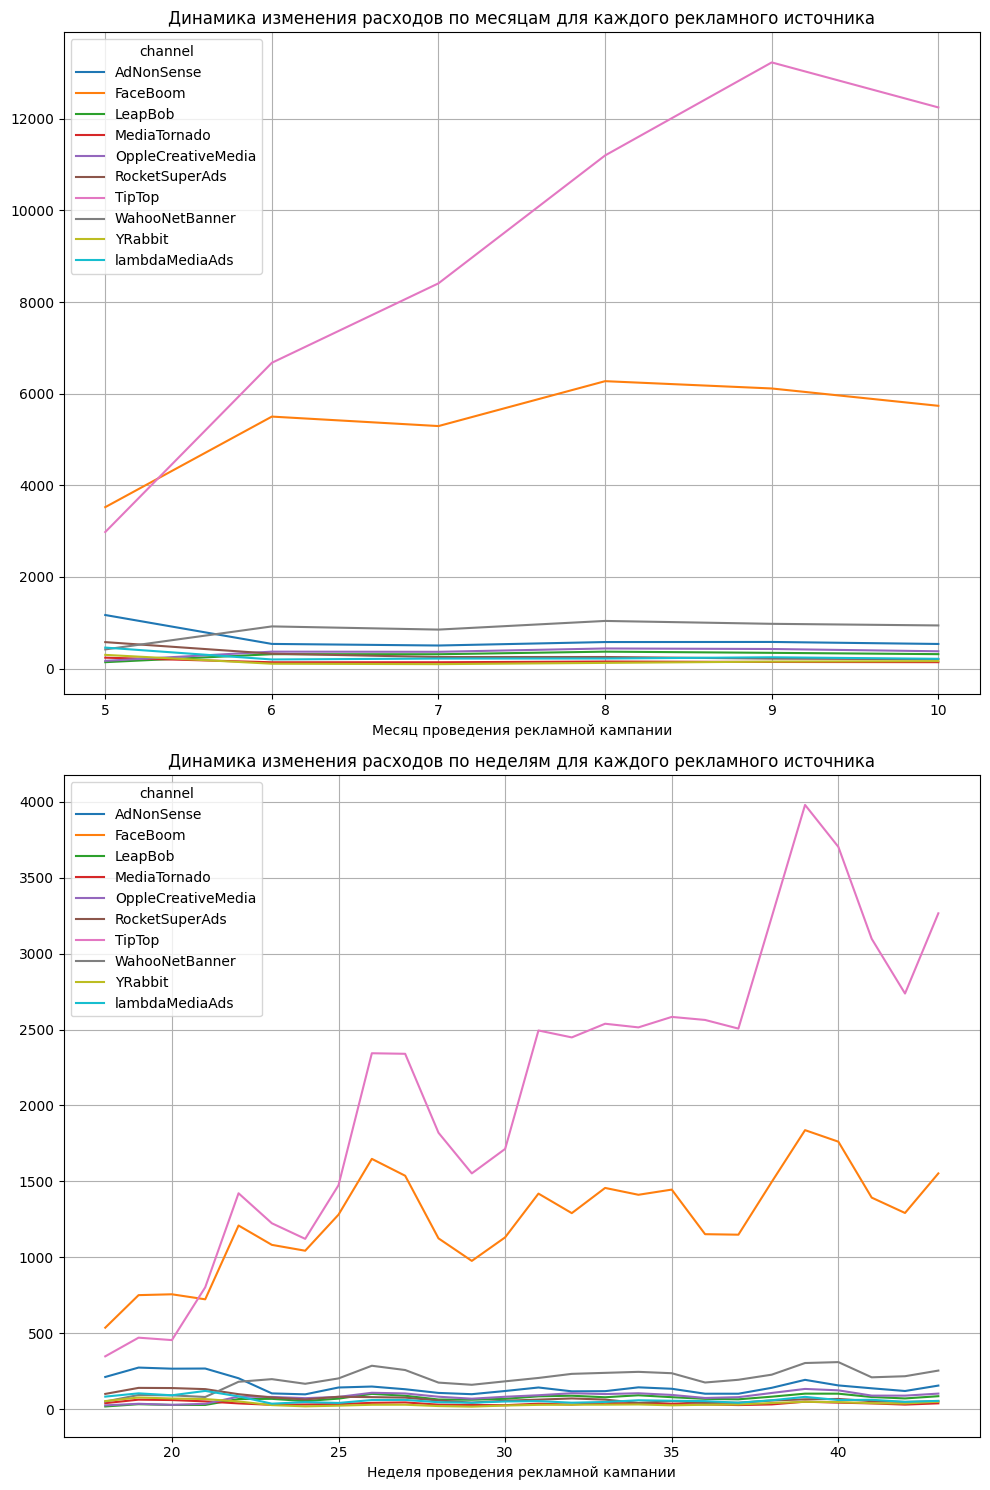

In [33]:
plt.figure(figsize=(10,15))
ax1 = plt.subplot(2,1,1)
costs_month.plot(grid=True, ax=ax1)
plt.xlabel('Месяц проведения рекламной кампании')
plt.title('Динамика изменения расходов по месяцам для каждого рекламного источника')
ax2 = plt.subplot(2,1,2)
costs_week.plot(grid=True,ax=ax2)
plt.xlabel('Неделя проведения рекламной кампании')
plt.title('Динамика изменения расходов по неделям для каждого рекламного источника')
plt.tight_layout()
plt.show()

*Вывод:* визуализация динамики изменения расходов подтвердила то, что больше всех денег вкладывается в рекламные кампании в таких источниках как Tip Top и FaceBoom. Наибольшие расходы наблюдаются в сентябре для Tip Top (более 12 000 у.е.) и в августе для FaceBoom (чуть больше 6 000 у.е.). 

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [34]:
cac_channel = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean').sort_values(by='acquisition_cost', ascending = False)
cac_channel['mean_cac'] = profiles['acquisition_cost'].mean()
cac_channel

,acquisition_cost,mean_cac
channel,,
TipTop,2.799003,0.703278
FaceBoom,1.113286,0.703278
AdNonSense,1.008054,0.703278
lambdaMediaAds,0.724802,0.703278
WahooNetBanner,0.602245,0.703278
RocketSuperAds,0.412095,0.703278
OppleCreativeMedia,0.250000,0.703278
YRabbit,0.218975,0.703278
MediaTornado,0.218717,0.703278


*Вывод:* среднее значение CAC для всех данных составляет 0.7 у.е, только 4 канала привлечения превысили его - Tip Top, FaceBoom, AdNonSense и lambdaMediaAds.
Наибольшее среднее значение стоимости привлечения одного клиента у канала Tip Top, 2.8 у.е. У FaceBoom и AdNonSense это значение чуть больше 1 у.е. У остальных каналов привлечения среднее значение CAC ниже 1 у.е., минимальное значение у LeapBob (0.21 у.е.).

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

Проанализируем окупаесть рекламы с помощью графиков LTV, ROI и графиков динамики LTV, CAC, ROI. Для этого будем использовать функции get_ltv и plot_ltv_roi. Момент анализа - 1 ноября 2019 года, горизонт анализа - 14 дней. Также из данных следует убрать органических пользователей, так как для этой категории нет затрат на рекламу.

In [35]:
profiles_without_organic = profiles.query('channel != "organic"')

In [36]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [37]:
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_without_organic, orders, observation_date, horizon_days)

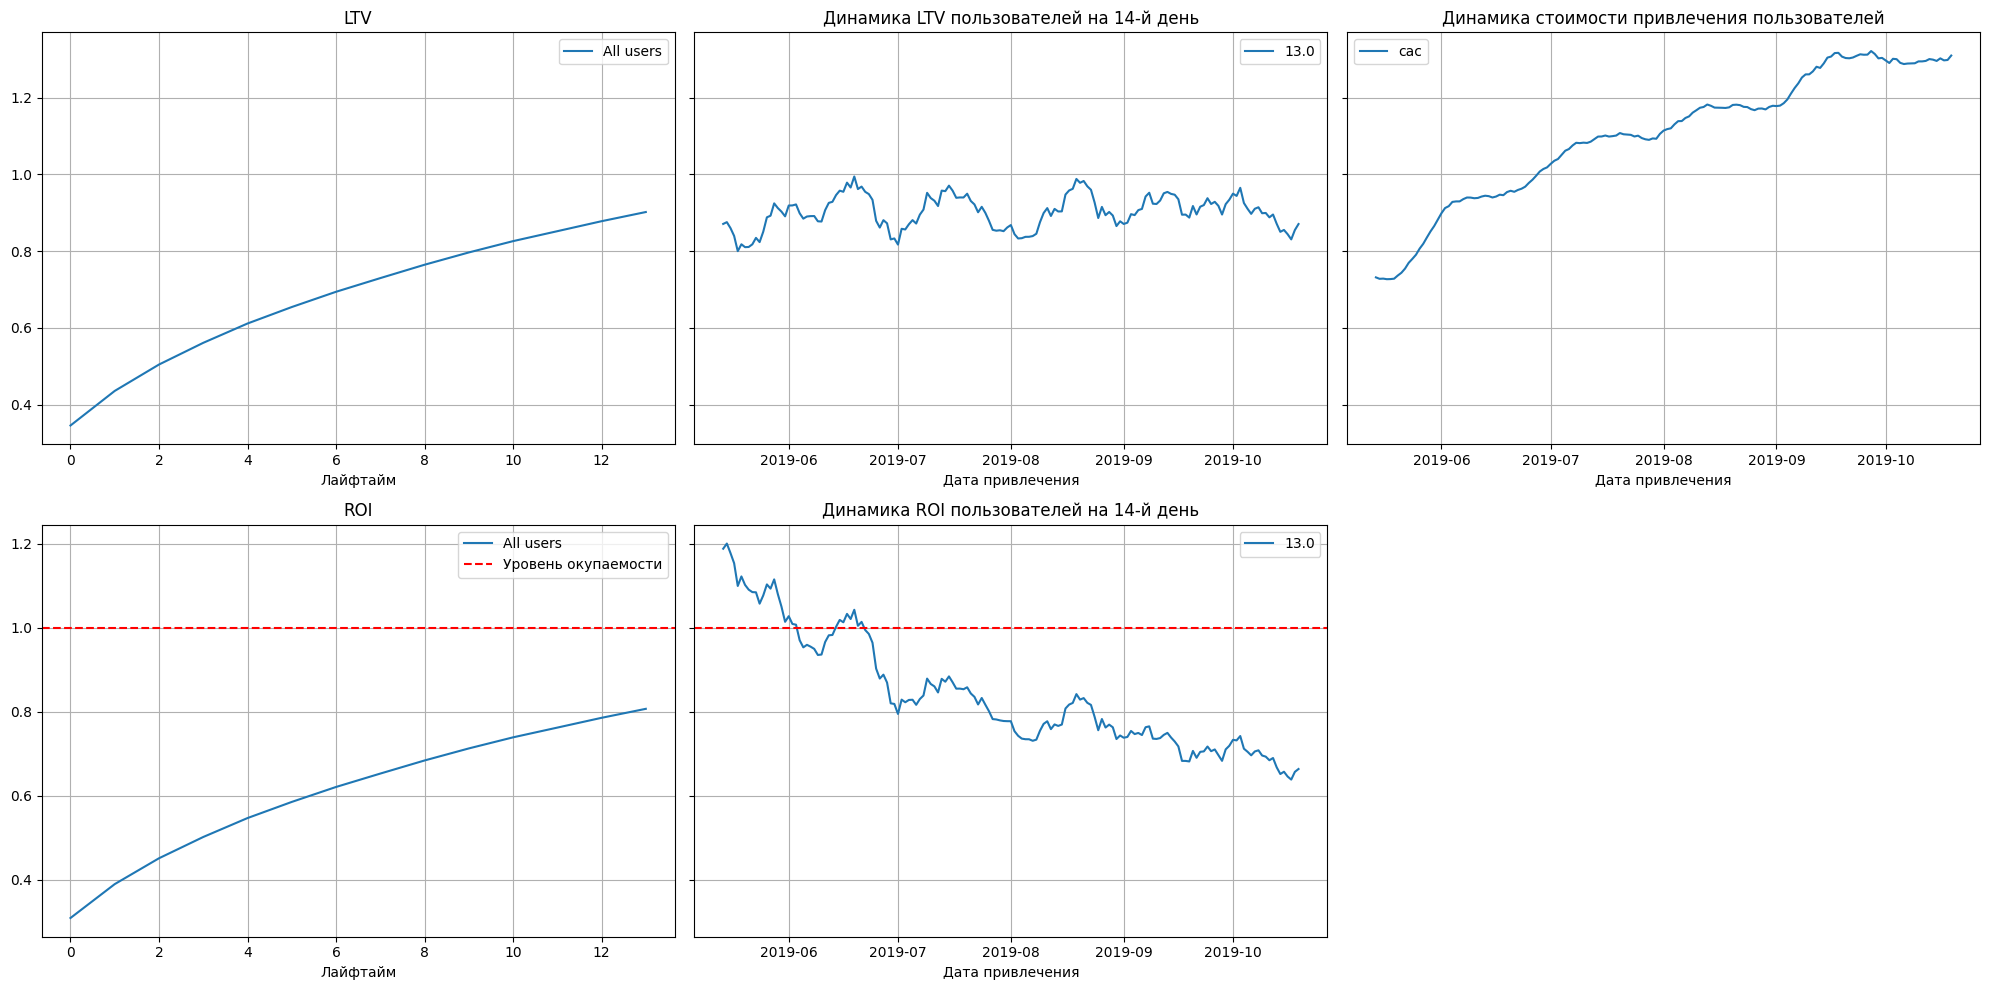

In [38]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 14)

*Вывод:* по графику ROI видно, что рекламные кампании не окупаются. 

Проверим конверсию пользователей. Сделаем это с помощью функций 

In [39]:
result_raw, conversion, conversion_history = get_conversion(profiles_without_organic, orders, observation_date, horizon_days)

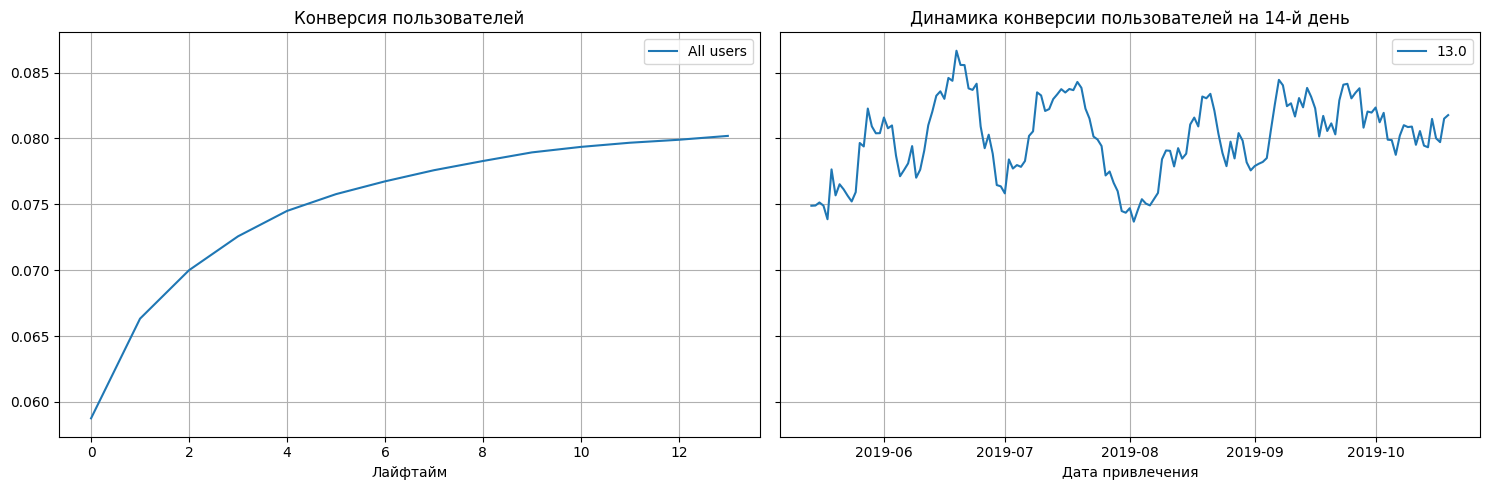

In [40]:
plot_conversion(conversion, conversion_history, horizon_days, 14)

*Вывод:* конверсия растет и на 14 день составляет чуть больше 8%. 

Проверим удержание пользователей, для этого будем использовать функции get_retention и plot_retention для визуализации результатов. 

In [41]:
result_raw, retention, retention_history = get_retention(profiles_without_organic, visits, observation_date, horizon_days)

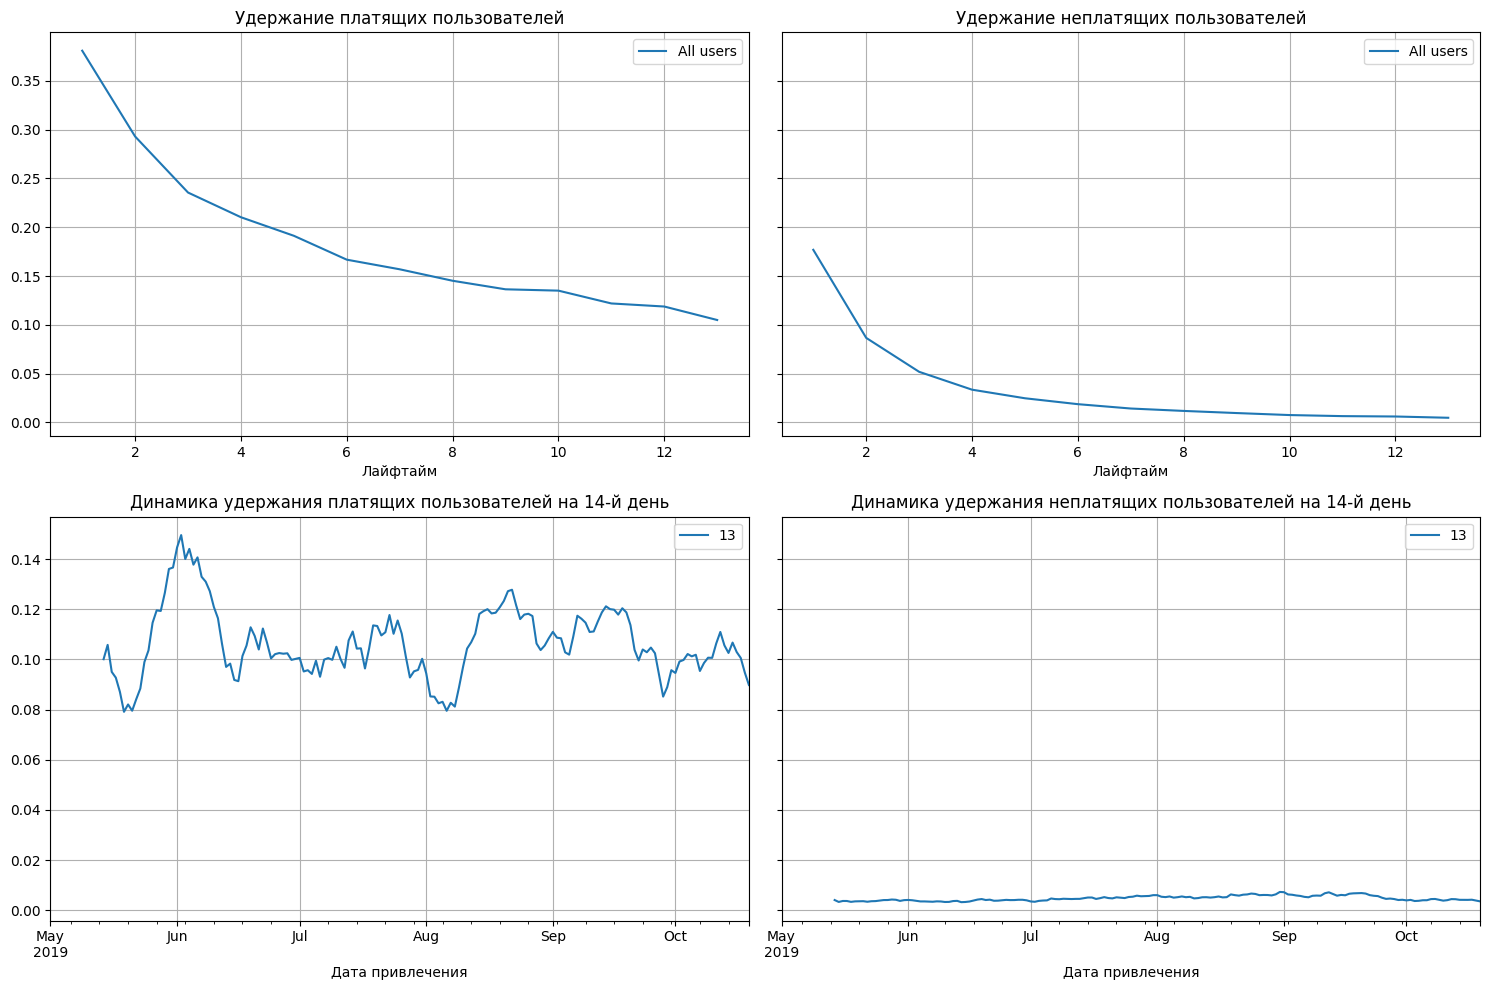

In [42]:
plot_retention(retention, retention_history, horizon_days, 14)

*Вывод:* удержание неплатящих пользователей намного ниже, чем удержание платящих пользователей. 

Проанализируем окупаемость рекламы с разбивкой по устройствам. Для этого при вызове функций get_ltv, get_conversion и get_retention в качестве параметра dimensions укажем channel.

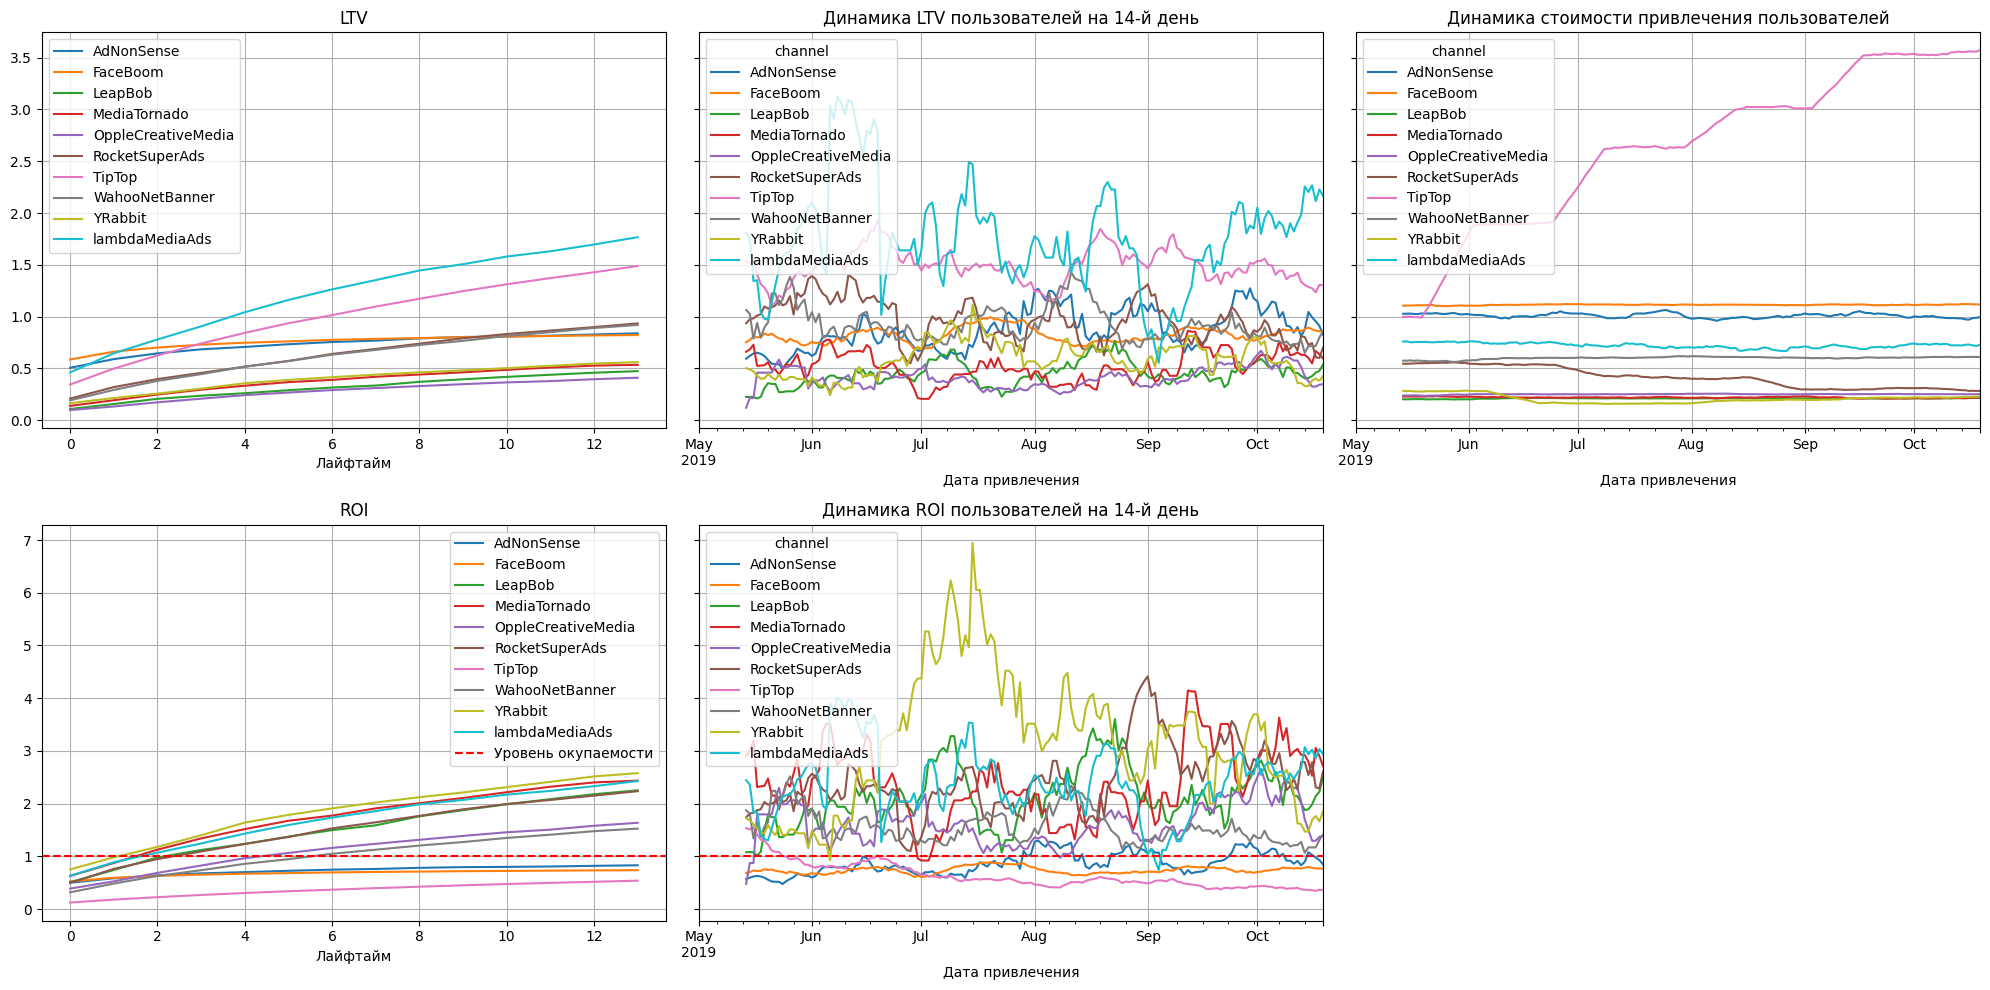

In [43]:
dimensions = ['channel']
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_without_organic, orders, observation_date, horizon_days, dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 14)

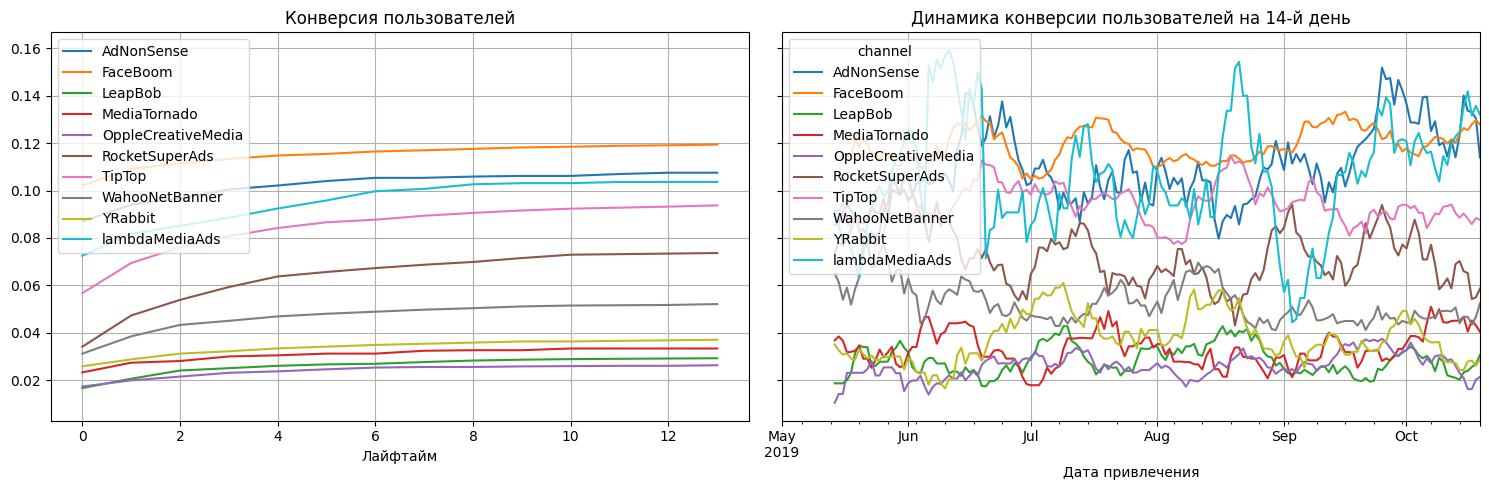

In [44]:
result_raw, conversion, conversion_history = get_conversion(profiles_without_organic, orders, observation_date, horizon_days, dimensions)
plot_conversion(conversion, conversion_history, horizon_days, 14)

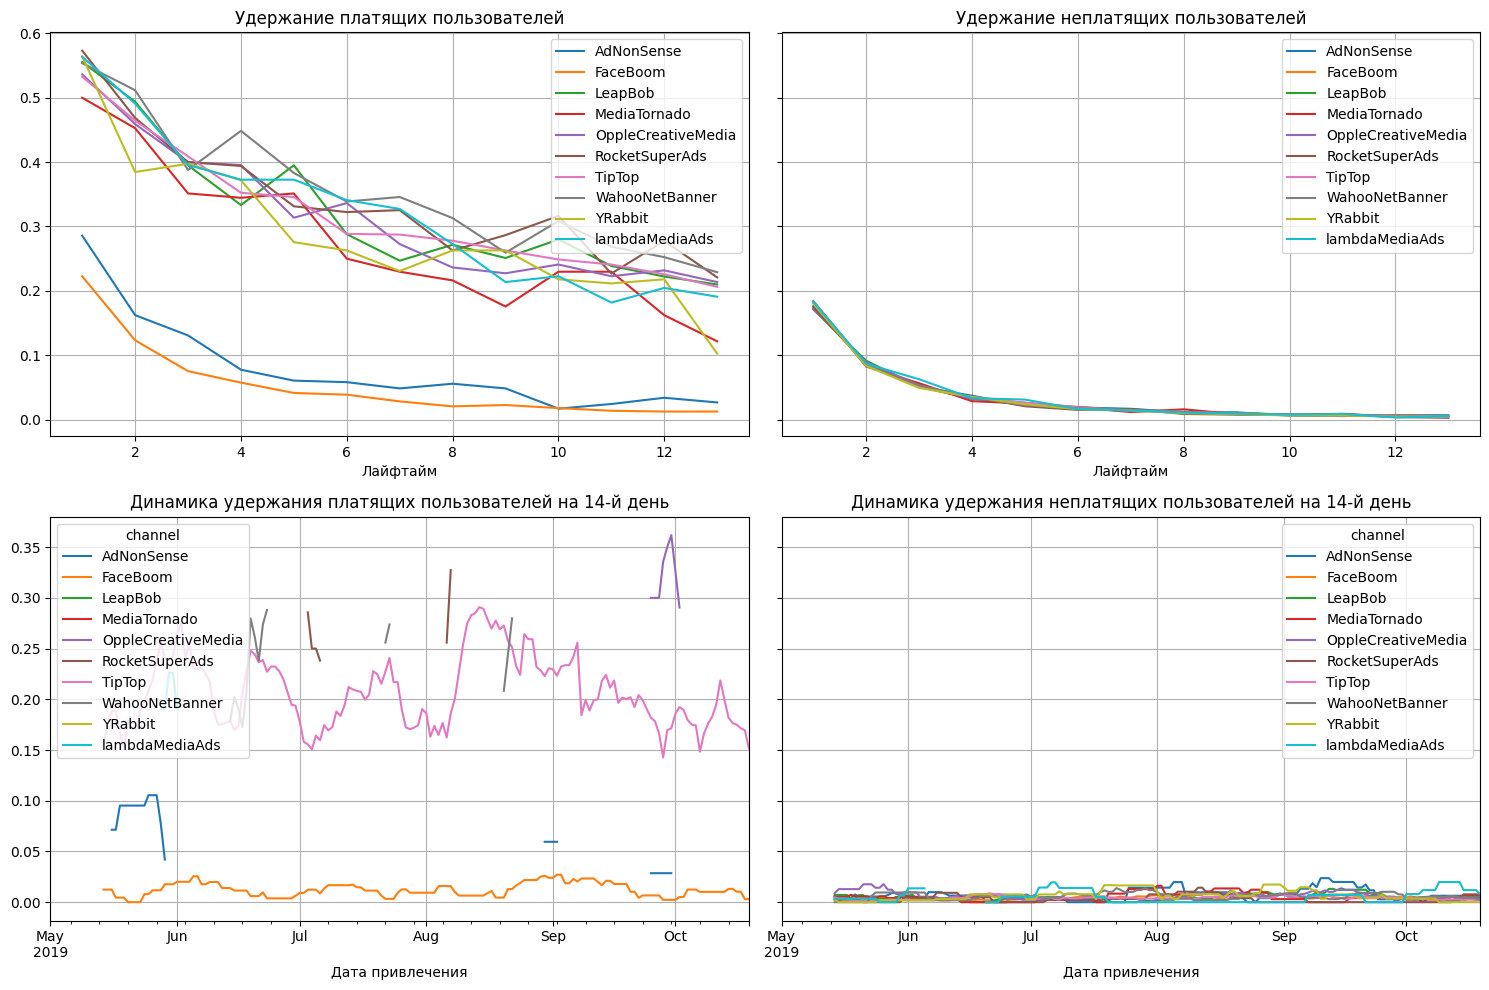

In [45]:
result_raw, retention, retention_history = get_retention(profiles_without_organic, visits, observation_date, horizon_days, dimensions)
plot_retention(retention, retention_history, horizon_days, 14)

*Вывод:* самая большая стоимость привлечения пользователей (CAC) и быстрый рост значений этого показателя у канала привлечения Tip Top. Но рекламные кампании данного канала привлечения не окупаются.
Самая высокая конверсия пользователей у канала привлечения FaceBoom, но при этом удержание платящих пользователей здесь самое низкое. Похожая ситуация у канала привлечения AdNonSense.

Проанализируем окупаемость рекламы с разбивкой по странам. Для этого при вызове функции get_ltv, get_conversion и get_retention в качестве параметра dimensions укажем region.

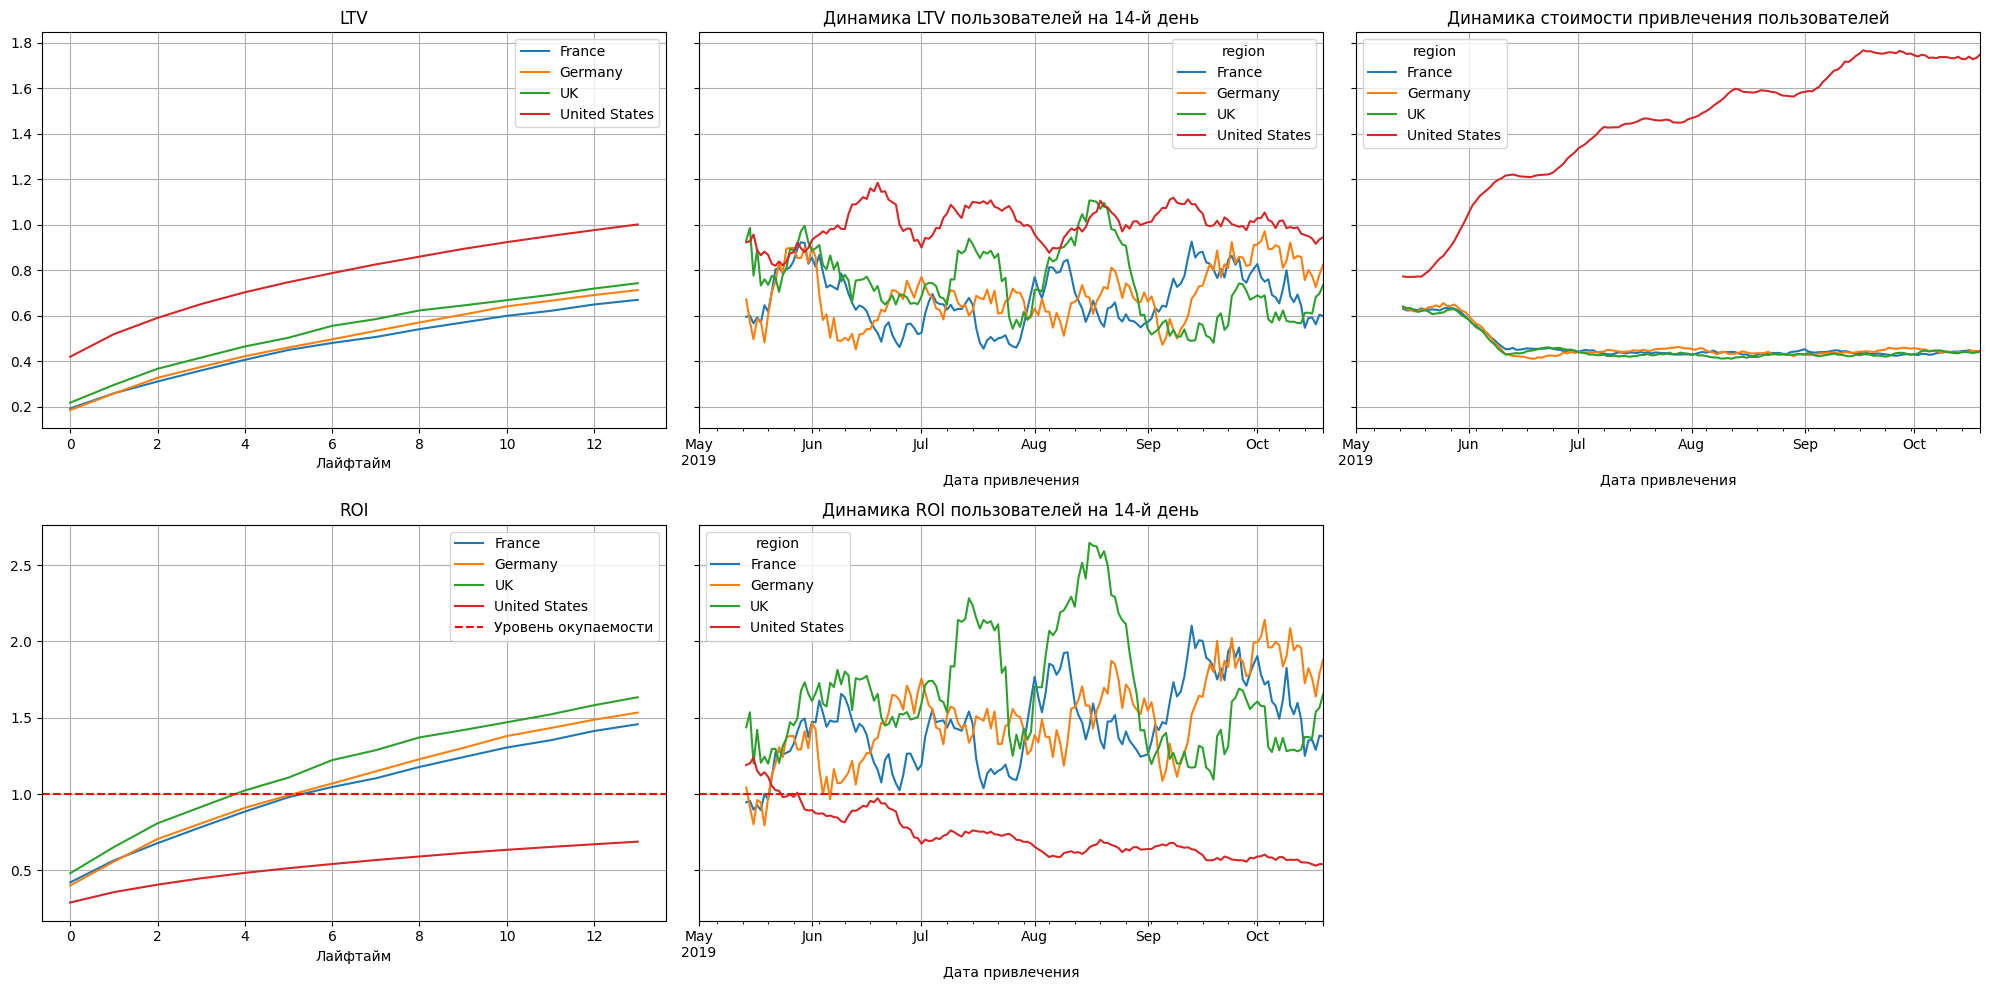

In [46]:
dimensions = ['region']
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_without_organic, orders, observation_date, horizon_days, dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 14)

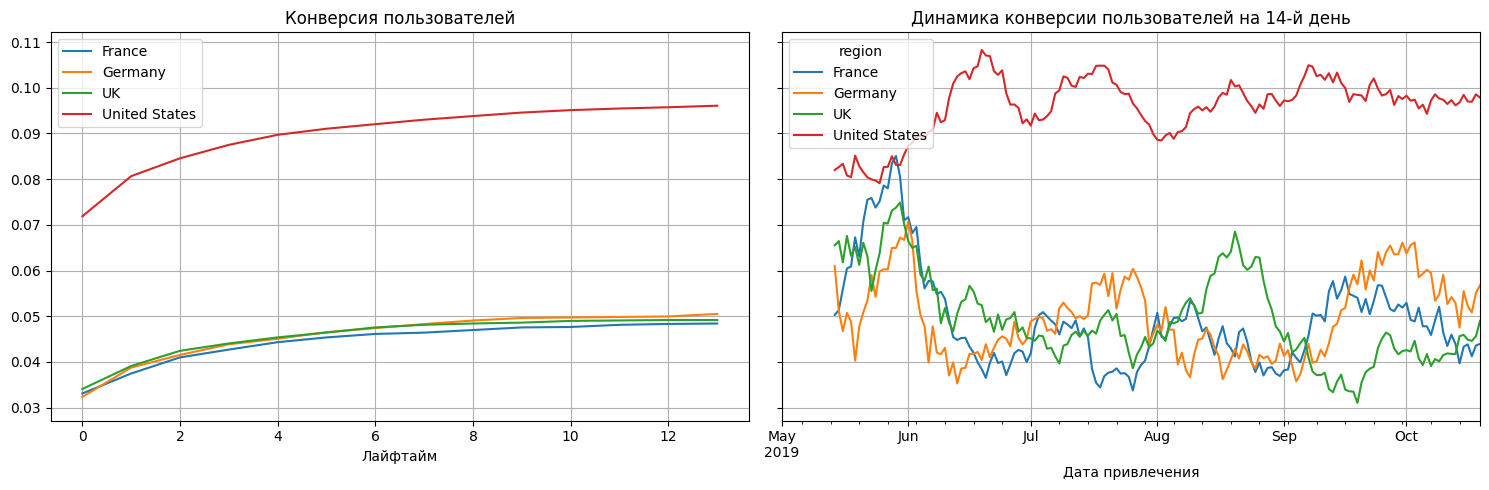

In [47]:
result_raw, conversion, conversion_history = get_conversion(profiles_without_organic, orders, observation_date, horizon_days, dimensions)
plot_conversion(conversion, conversion_history, horizon_days, 14)

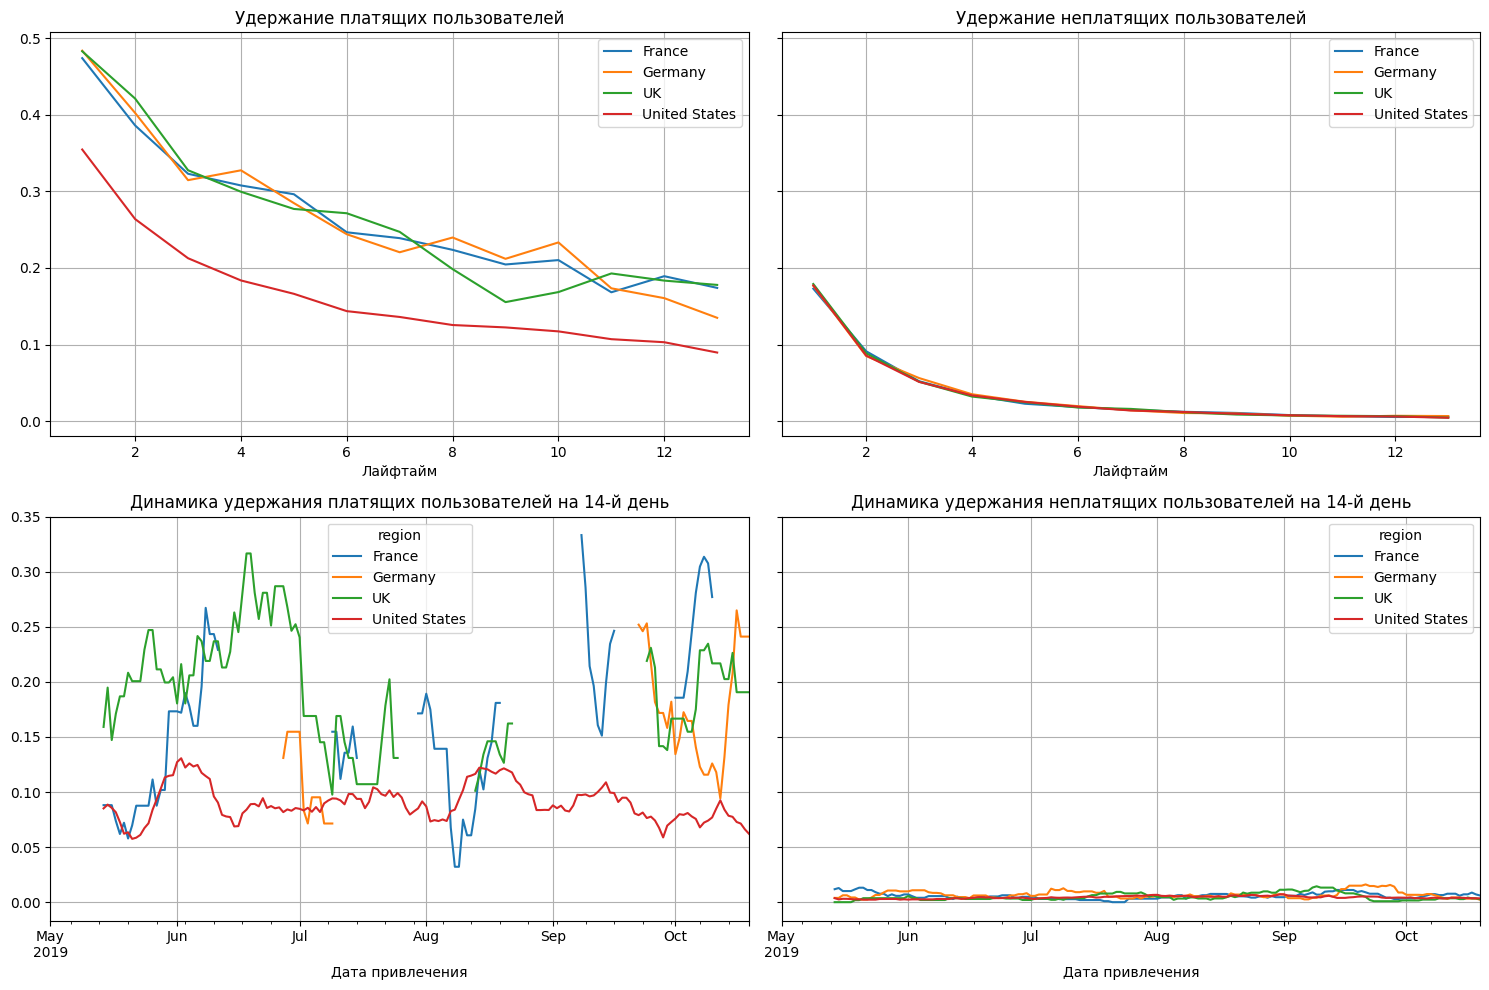

In [48]:
result_raw, retention, retention_history = get_retention(profiles_without_organic, visits, observation_date, horizon_days, dimensions)
plot_retention(retention, retention_history, horizon_days, 14)

*Вывод:* в США рекламные кампании не окупились, это связано с большими значениями CAC и низким удержанием платящих пользователей, несмотря на самое высокое значение конверсии пользователей. 

Проанализируем окупаемость рекламы с разбивкой по устройствам. Для этого при вызове функции get_ltv, get_conversion и get_retention в качестве параметра dimensions укажем device.

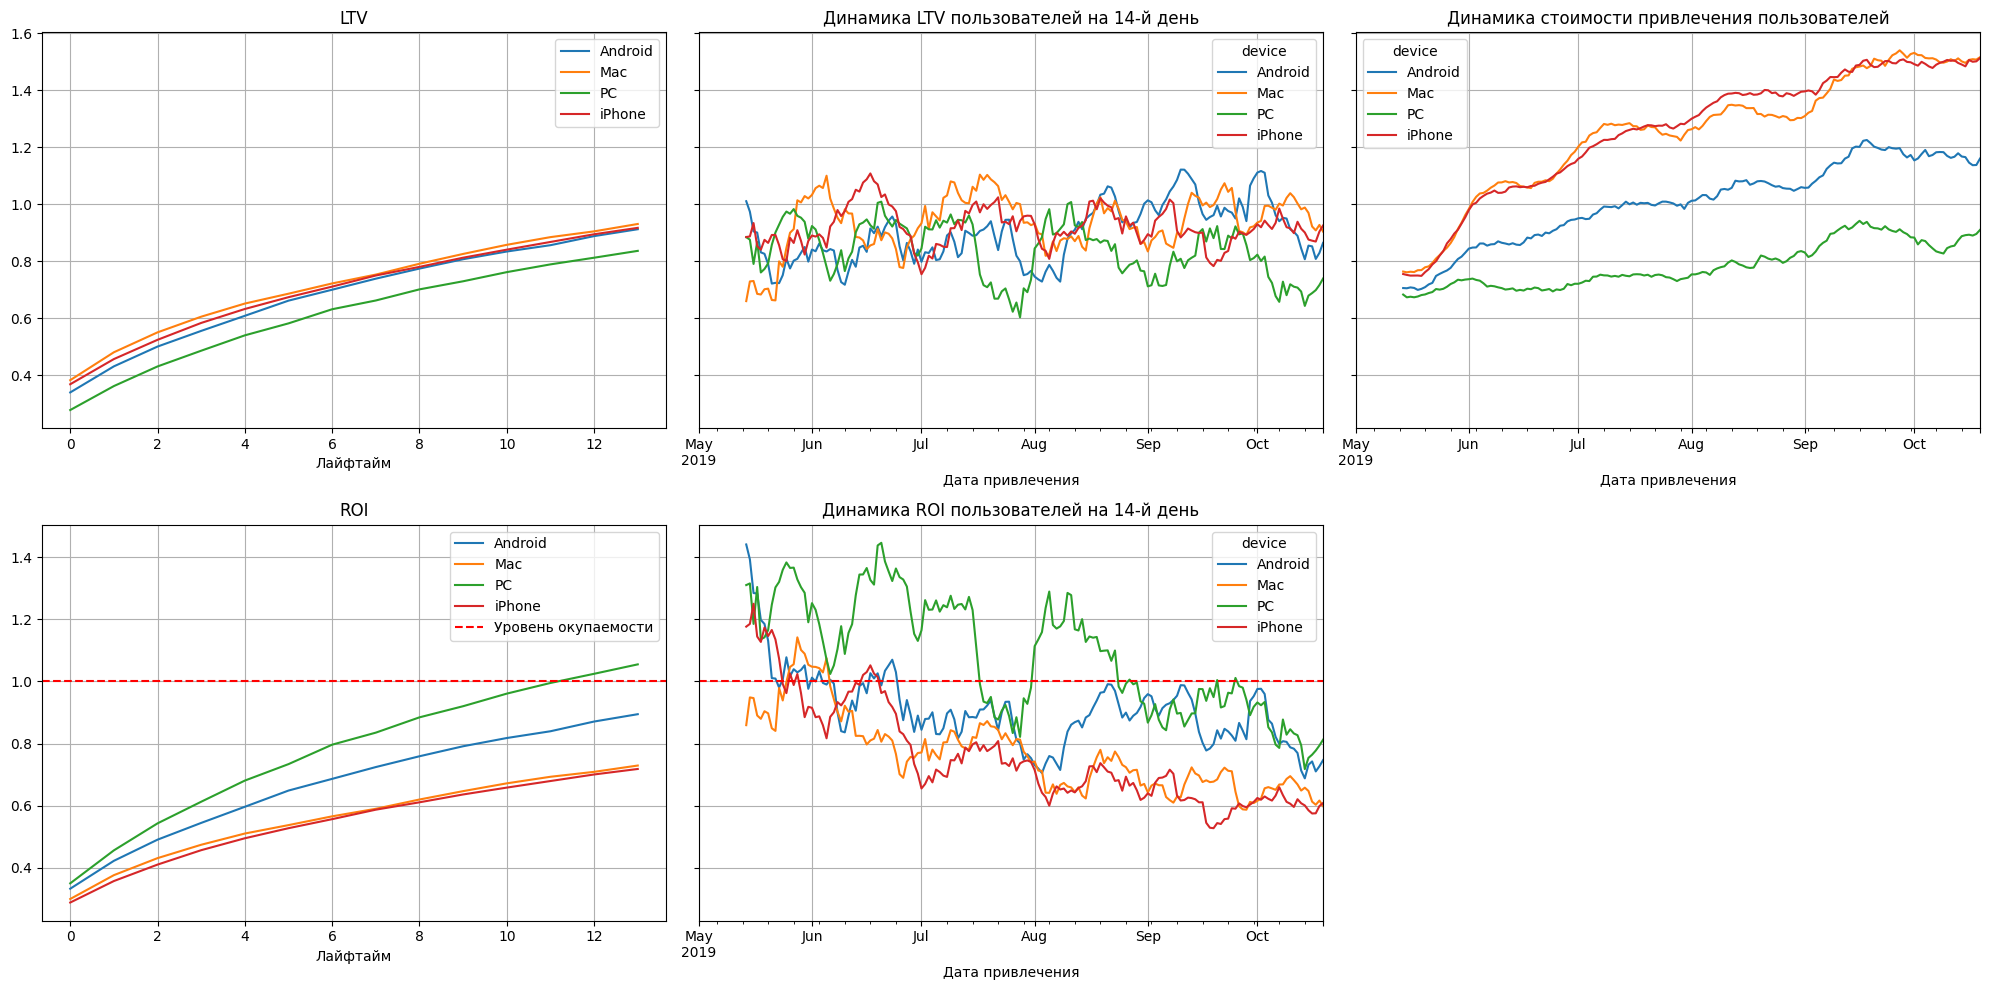

In [49]:
dimensions = ['device']
result_raw, ltv, ltv_history, roi, roi_history = get_ltv(profiles_without_organic, orders, observation_date, horizon_days, dimensions)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, 14)

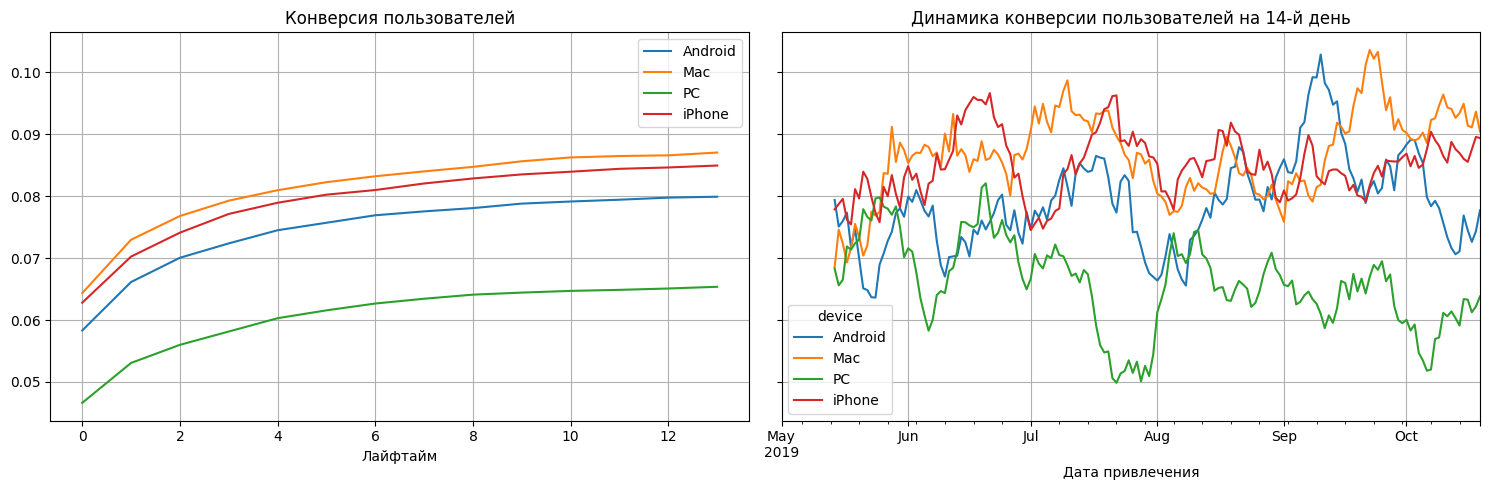

In [50]:
result_raw, conversion, conversion_history = get_conversion(profiles_without_organic, orders, observation_date, horizon_days, dimensions)
plot_conversion(conversion, conversion_history, horizon_days, 14)

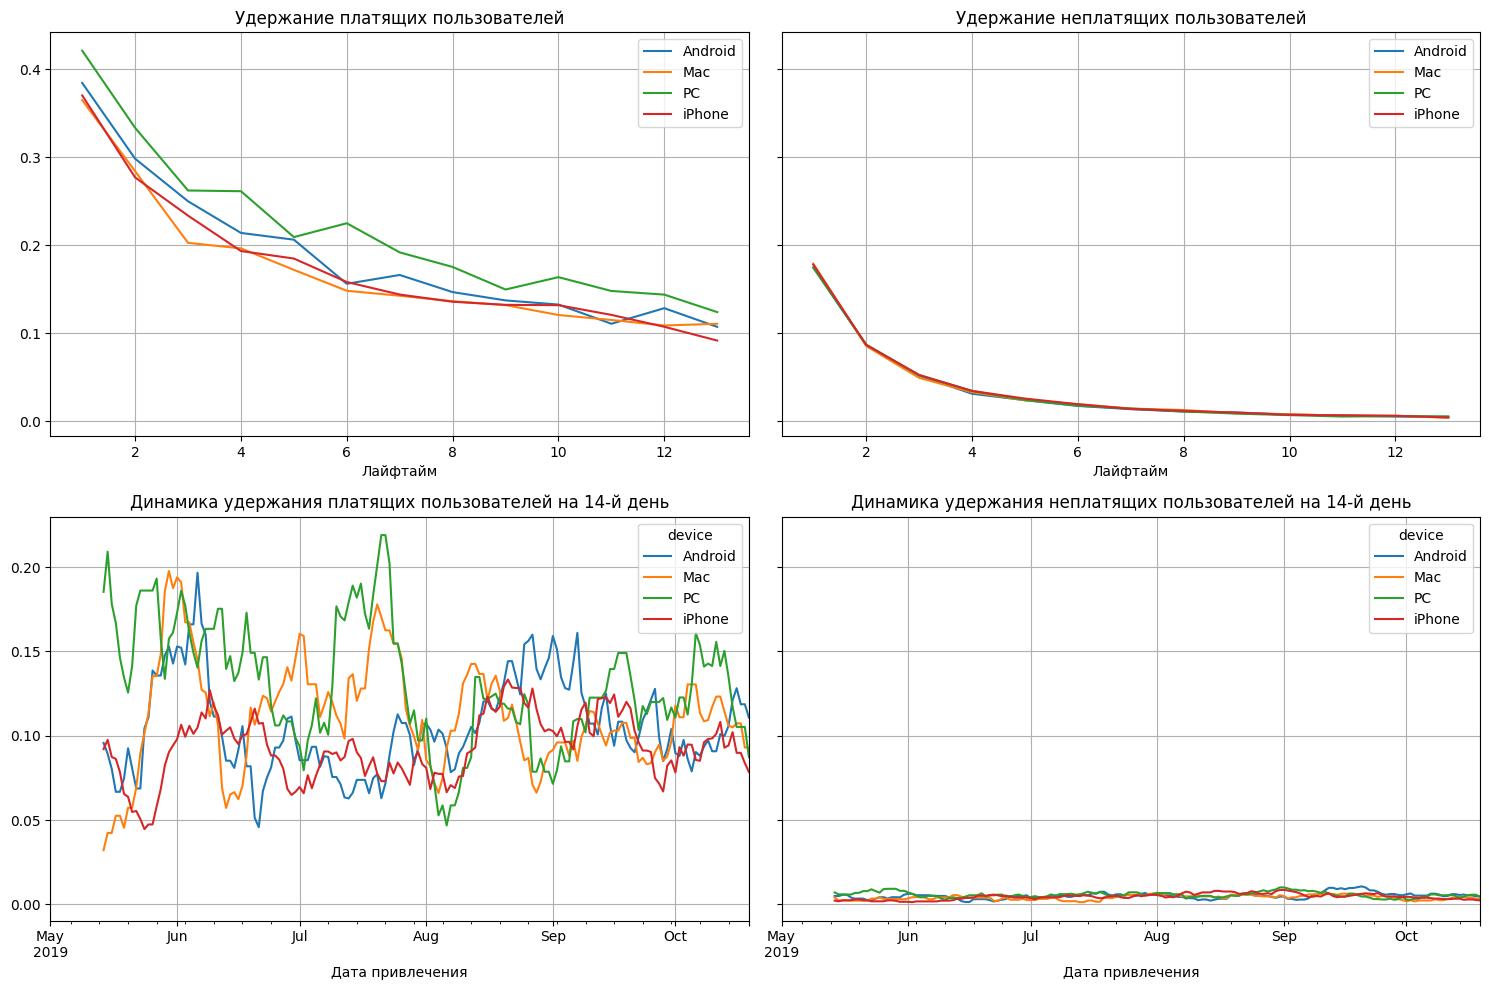

In [51]:
result_raw, retention, retention_history = get_retention(profiles_without_organic, visits, observation_date, horizon_days, dimensions)
plot_retention(retention, retention_history, horizon_days, 14)

*Вывод:* рекламные кампании для устройств IPhone, Mac и Android не окупаются. У IPhone и Mac самые высокие показатели CAC и конверсии пользователей, но при этом низкие показатели удержания платящих пользователей.

**Вывод:** В целом рекламные кампании приложения Procrastinate Pro+ не окупились в рассматриваемом периоде. Особое внимание необходимо обратить на кампании для канала привлечения Tip Top, США и таких устройств, как IPhone, Mac и Andriod, так как в данных категориях самые большие расходы на привлечение пользователей, при этом реклама не окупается. Другие каналы привлечения, страны и устройства окупаются.

## Выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

В ходе работы над проектом было сделано следующее:
- Описаны необходимы для исследования функции: для вывода общей информации о датасете, создания сводных таблиц, создания профилей пользователей, подсчёта Retention Rate, подсчёта конверсии, подсчёта LTV, сглаживания данных, построения графика Retention Rate, построения графика конверсии, визуализации LTV и ROI. 
- Изучены данные о пользователях приложения Procrastinate Pro+, привлечённых с 1 мая по 27 октября 2019 года: лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы.
- Проведена проверка на наличие пропусков и дубликатов в данных. 
- Изменены названия стобцов на "змеиный регистр".
- Столбцы session_start и session_end в датасете visits и event_dt в датасете orders приведены к типу datetime, а столбец dt в датасете costs к типу date. 
- Составлены профили пользователей и определены минимальная и максимальная даты их привлечения (1 мая 2019 года и 27 октября 2019 года соответственно).
- Составлены сводные таблицы с группировкой по странам, устройствам и каналам привлечения для определения групп с наибольшим числом платящих пользователей. Получены следующие результаты: общая доля платящих пользователей составляет 5.92%. В разбивке по странам наибольшее число платящих пользователей в США (6.9%), наименьшее во Франции (3.8%). В разбивке по устройствам больше всего платящих среди пользователей Mac (6.36%), меньше всего у пользователей PC (5%). В разбивке по каналам привлечения больше всего платящих пользователей среди тех, кто пришел из FaceBoom (12.2%), меньше всего среди органических пользователей (2%). 
- Посчитана общая сумма расходов на маркетинг. Она составялет 105 497 у.е.
- При группировки данных из датасета costs по каналам привлечения было выяснено, что больше всего средств было потрачено на рекламу в Tip Top - 54 751.30 у.е., меньше всего - в YRabbit (944.22 у.е.). Визуализация динамики изменения расходов подтвердила то, что больше всех денег вкладывается в рекламные кампании в таких источниках как Tip Top и FaceBoom. Наибольшие расходы наблюдаются в сентябре для Tip Top (более 12 000 у.е.) и в августе для FaceBoom (чуть больше 6 000 у.е.).
- Определено среднее значение стоимости привлечения одного пользователя (CAC) для каждого источника: наибольшее среднее значение стоимости привлечения одного клиента у канала Tip Top, 2.8 у.е. У FaceBoom и AdNonSense это значение чуть больше 1 у.е. У остальных каналов привлечения среднее значение CAC ниже 1 у.е., минимальное значение у LeapBob (0.21 у.е.). Среднее значение CAC для всех данных равно 0.7 у.е, только 4 канала привлечения превысили его - Tip Top, FaceBoom, AdNonSense и lambdaMediaAds.
- Проведена оценка окупаемсоти рекламы, как в целом, так и с разбивкой по каналам привлечения, регионам и устройствам. В результате мы выяснили следующее: рекламные кампании в рассматриваемом периоде не окупились. Причинами этого являются большие расходы на привлечение пользователей через канал Tip Top, из США и тех, кто используют IPhone, Mac и Andriod, а также низкое удержание платящих пользователей в этих группах. Для данных категорий рекламные кампании не окупились. Отделу маркетинга следует пересмотреть работу в данных направлениях. 